# 1 month salt budget test for panant-01

In [1]:
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
from matplotlib.colors import to_rgba

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
lat_slice = slice(-79,-59)

# Importing data
paths_1 = np.sort(glob.glob('/scratch/x77/kc5856/mom6/archive/panant-ssp126-sofia-expt-3393fa55/output001/*.ocean_month.nc'))
paths_2 = np.sort(glob.glob('/scratch/x77/kc5856/mom6/archive/panant-ssp126-sofia-expt-3393fa55/output001/*.ocean_month_z.nc'))

In [7]:
# Time variant variables
def preprocess_1(ds):
    ds = ds[['wfo','lrunoff']].sel(yh=lat_slice)
    return ds

def preprocess_2(ds):
    ds = ds[['so','S_advection_xy','Sh_tendency_vert_remap','osalttend','osaltpmdiff','osaltdiff','boundary_forcing_salt_tendency']].sel(yh=lat_slice)
    return ds

pan = xr.open_mfdataset(paths_1, preprocess = preprocess_1, chunks = 'auto')
pan_z = xr.open_mfdataset(paths_2, preprocess = preprocess_2, chunks = 'auto')

In [6]:
pan_z

<xarray.Dataset> Size: 6GB
Dimensions:                 (time: 2, z_l: 75, yh: 460, xh: 3600)
Coordinates:
  * time                    (time) object 16B 1991-03-16 12:00:00 1991-04-16 ...
  * z_l                     (z_l) float64 600B 0.5413 1.681 ... 5.709e+03
  * yh                      (yh) float64 4kB -79.0 -78.95 ... -59.08 -59.03
  * xh                      (xh) float64 29kB -279.9 -279.8 ... 79.85 79.95
Data variables:
    so                      (time, z_l, yh, xh) float32 994MB dask.array<chunksize=(2, 22, 192, 1030), meta=np.ndarray>
    S_advection_xy          (time, z_l, yh, xh) float32 994MB dask.array<chunksize=(2, 22, 192, 1030), meta=np.ndarray>
    Sh_tendency_vert_remap  (time, z_l, yh, xh) float32 994MB dask.array<chunksize=(2, 22, 192, 1030), meta=np.ndarray>
    osalttend               (time, z_l, yh, xh) float32 994MB dask.array<chunksize=(2, 22, 192, 1030), meta=np.ndarray>
    osaltpmdiff             (time, z_l, yh, xh) float32 994MB dask.array<chunksize=(2, 22, 192, 1030), meta=np.ndarray>
    osaltdiff               (time, z_l, yh, xh) float32 994MB dask.array<chunksize=(2, 22, 192, 1030), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19910301.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [9]:
# LHS: tendency + advection

lhs_salt = {
    'tendency' : pan_z.osalttend,
    'advection_xy' : pan_z.S_advection_xy,
    'advection_vert' : pan_z.Sh_tendency_vert_remap,
}


# RHS: diffusion + boundary forcing

rhs_salt = {
    'surface_forcing' : pan_z.boundary_forcing_salt_tendency, # maybe change?
    'vertical_diffusion' : pan_z.osaltdiff,
    'neutral_diffusion' : pan_z.osaltpmdiff,
}

Cell below is a work in progress:

At the moment taking `time`=0 to just look at first month - but I'm unsure this is still giving me the right evolution over time that I am looking for.

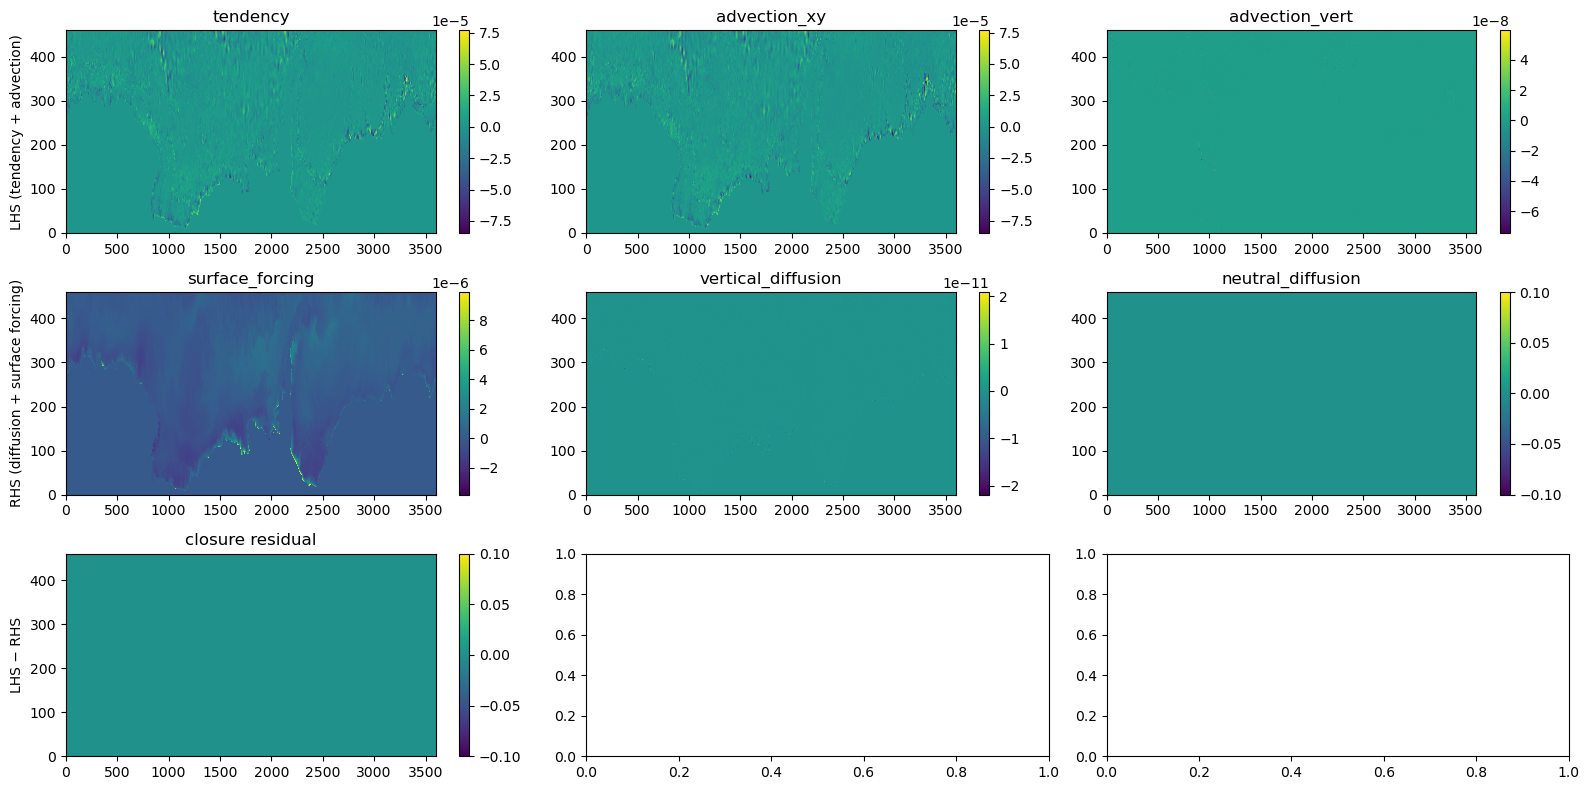

In [13]:
zdim = 'z_l'  # MOM6 vertical grid dimension

fig, ax = plt.subplots(
    figsize=(16, 8),
    nrows=3,
    ncols=max(len(lhs_salt), len(rhs_salt))
)
ax = ax.reshape(3, -1)  # flatten for consistent indexing

# -----------------------
# LHS terms
# -----------------------
for i, (name, da) in enumerate(lhs_salt.items()):
    da2d = da.sum(zdim).squeeze()
    if 'time' in da2d.dims:
        da2d = da2d.isel(time=0)
    da2d = da2d.compute()
    im = ax[0, i].pcolormesh(da2d)
    plt.colorbar(im, ax=ax[0, i])
    ax[0, i].set_title(name)

# -----------------------
# RHS terms
# -----------------------
for i, (name, da) in enumerate(rhs_salt.items()):
    da2d = da.sum(zdim).squeeze()
    if 'time' in da2d.dims:
        da2d = da2d.isel(time=0)
    da2d = da2d.compute()
    im = ax[1, i].pcolormesh(da2d)
    plt.colorbar(im, ax=ax[1, i])
    ax[1, i].set_title(name)

# -----------------------
# Closure residual
# -----------------------
lhs_total = pan_z.osalttend + pan_z.S_advection_xy + pan_z.Sh_tendency_vert_remap
rhs_total = pan_z.boundary_forcing_salt_tendency + pan_z.osaltdiff + pan_z.osaltpmdiff

residual = (lhs_total - rhs_total).sum(zdim).squeeze()
if 'time' in residual.dims:
    residual = residual.isel(time=0)
residual = residual.compute()
vmax = np.abs(residual).max()
im = ax[2, 0].pcolormesh(residual, vmin=-vmax, vmax=vmax)
plt.colorbar(im, ax=ax[2, 0])
ax[2, 0].set_title('closure residual')

# -----------------------
# Row labels
# -----------------------
ax[0, 0].set_ylabel('LHS (tendency + advection)')
ax[1, 0].set_ylabel('RHS (diffusion + surface forcing)')
ax[2, 0].set_ylabel('LHS − RHS')

plt.tight_layout()
